In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from collections import defaultdict
import json
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../data/race_data/2017.csv')

In [3]:
new_times_s = []
for index, time in df['Session Time'].iteritems():
    if time.count(':') == 1:
        new_times_s.append(datetime.strptime(time, '%M:%S.%f'))
    else:
        new_times_s.append(datetime.strptime(time, '%H:%M:%S.%f'))
df['Session Time'] = new_times_s

In [4]:
df.to_csv('../../data/2017/2017_mod.csv', index=False, date_format='%Y-%m-%d %H:%M:%S.%f')

In [9]:
MAXTIME = df['Session Time'].max()
start_date = datetime(1900, 1, 1)
MAXTIME = (MAXTIME - start_date).total_seconds()
MAXTIME

6139.686

In [10]:
pit_times = {}
for car in list(pd.unique(df.Car)):
    df_car = df.loc[(df['Car'] == car) & (df['Location'] == 'Pit')]
    pt = list(pd.unique(df_car['Session Time']))
    d_zero = np.datetime64('1900-01-01T00:00:00')
    pt = [(d - d_zero) / np.timedelta64(1, 's') for d in pt]
    pt = [0] + pt
    pit_times[car] = pt

In [11]:
flagtimes = [1560.0]
cars = []

def getLastPit(car, time):
    lp = max([t for t in pit_times[car] if t <= time])
    return (time - lp) / 60

with open('../../data/2017/17_stopped_car_pit.csv', 'w') as f:
    f.write('Car,Flag Time,Last Pit\n')
    
    for t in zip(cars, flagtimes):
        f.write("%s,%s,%s\n"%(t[0], t[1], getLastPit(t[0], t[1])))

In [12]:
def get_risk_score(x):
    MEAN1 = 0
    STD1 = 21.751478190190515
    return norm.pdf(x, MEAN1, STD1)*10

In [13]:
intervals = pd.read_csv('../../data/2017/17_start_end.csv')
intervals = intervals.to_records(index=False)
intervals = [t for t in intervals if t[0] in flagtimes]
intervals

[(1560., 2580.)]

In [14]:
risk_score = {}
sus_score = {}
intervals_c = np.copy(intervals)
for t in range(0, int(MAXTIME), 60):
    agg_risk = 0
    agg_sus = 0
    for car in pit_times:
        if len(intervals_c) > 0 and intervals_c[0][0] < t < intervals_c[0][1]:
            pass
        elif len(intervals_c) > 0 and t > intervals_c[0][1]:
            intervals_c = intervals_c[1:]
        else:
            agg_risk += get_risk_score(getLastPit(car, t))
        
        previous = [time for time in pit_times[car] if time <= t]
        pt = 0
        sus = 0
        for p in previous[1:]:
            if p - pt < 600:
#                 print(previous)
                sus += 100
            elif p - pt < 900:
                sus += 80
            elif p - pt < 1500:
                sus += 30
            else:
                sus -= .25
            pt = p
        agg_sus += sus
        
    risk_score[t] = agg_risk
    sus_score[t] = agg_sus

In [15]:
sus_deriv = {}
intervals_c = np.copy(intervals)
for t in range(60, int(MAXTIME), 60):
    sus_deriv[t] = (sus_score[t] - sus_score[t-60]) / 60
    if len(intervals_c) > 0:
        if intervals_c[0][0] < t < intervals_c[0][1]:
            sus_deriv[t] = 0
        elif t > intervals_c[0][1]:
            intervals_c = intervals_c[1:]

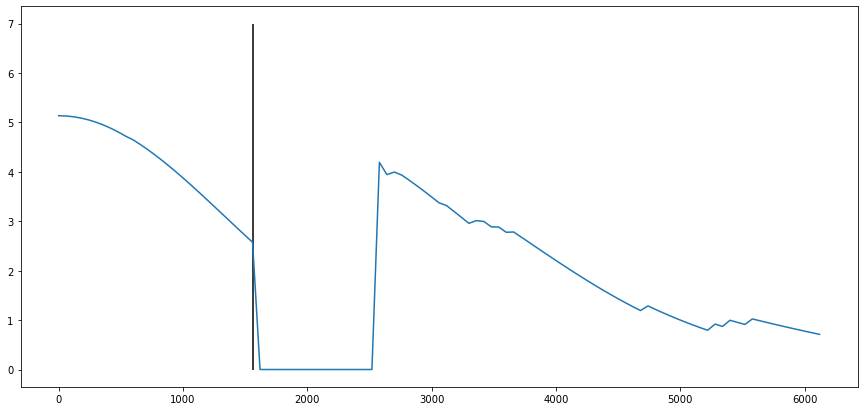

In [16]:
plt.figure(figsize=(15,7))
plt.plot(list(risk_score.keys()), list(risk_score.values()))
plt.vlines(flagtimes, 0, 7)
plt.show()

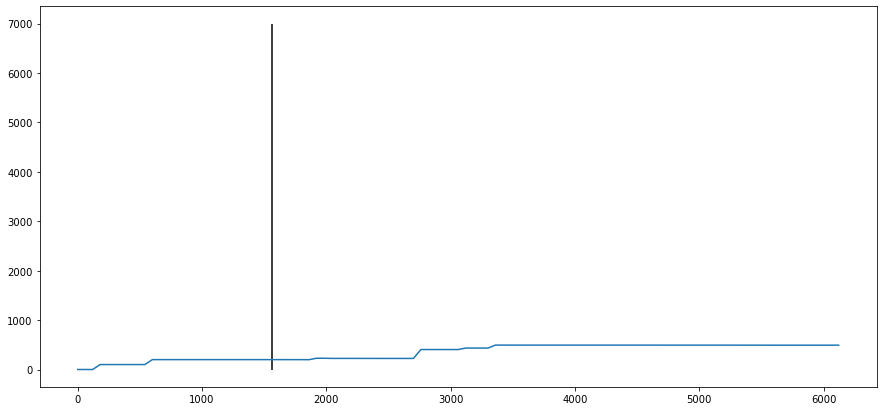

In [17]:
plt.figure(figsize=(15,7))
plt.plot(list(sus_score.keys()), list(sus_score.values()))
plt.vlines(flagtimes, 0, 7000)
plt.show()

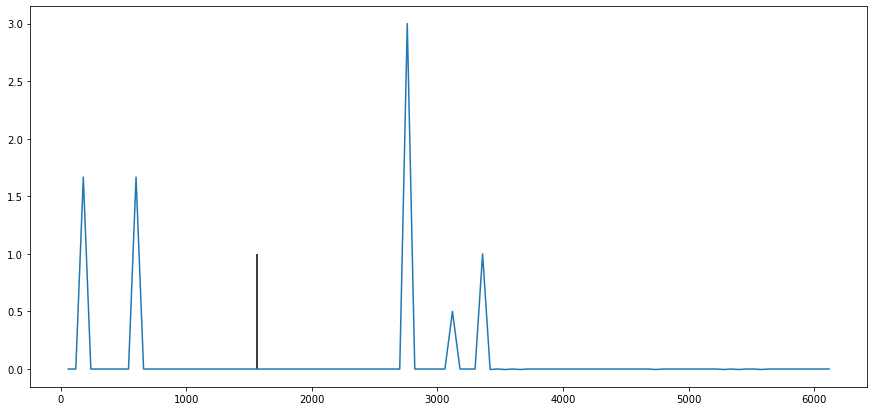

In [18]:

plt.figure(figsize=(15,7))
plt.plot(list(sus_deriv.keys()), list(sus_deriv.values()))
plt.vlines(flagtimes, 0, 1)
plt.show()

In [26]:
with open('../../data/2017/17_risk_score.csv', 'w') as f:
    f.write('Time,Risk Score\n')
    for k,v in risk_score.items():
        f.write('%s,%s\n'%(k,v))

In [27]:
with open('../../data/2017/17_sus_deriv.csv', 'w') as f:
    f.write('Time,Sus Deriv\n')
    for k,v in sus_deriv.items():
        f.write('%s,%s\n'%(k,v))

In [12]:
cars = [38, 19, 74, 19, 47]
times = [27940, 36360, 65440, 68460, 70540]
stopped_pit = [(t[0], t[1], getLastPit(t[0], t[1])) for t in zip(cars, times)]

with open('../../data/2020/20_stopped_car_pit.csv', 'w') as f:
    f.write('Car,Flag Time,Last Pit\n')
    for s in stopped_pit:
        f.write("%s,%s,%s\n"%(s[0], s[1], s[2]))

In [ ]:
# stopped cars: [47, 19, 74, 19, 38]

In [11]:
# last_pit = {}
# for t in range(20, MAXTIME, 20):
#     all_times = []
#     for car in pit_times.keys():
#         lp = max(filter(lambda pt: pt < t, pit_times[car]))
#         all_times.append(t - lp)
#     last_pit[t] = np.average(all_times) / 60